# Module 2

Module 2 starts off by introducing the one-way Anova test. 
Here we will not go into any details regarding it, but will only provide the tools to perform the analysis.

The format of the analysis and the presentation of the results will be based on the Anova table in section 15.2.2 of the course book.

We begin by importing the modules that we will need, like in module 1.

In [1]:
import numpy
from scipy import stats
import pandas

import itertools
from tabulate import tabulate
from statsmodels.stats.multicomp import pairwise_tukeyhsd

The new modules that we are including are itertools ([itertools documentation](https://docs.python.org/2/library/itertools.html)) which gives us some powerful tools for iterating through lists, tabulate ([tabulate documentation](https://pypi.org/project/tabulate/)) which helps us present our results in a nice manner, and the pairwise tukey test from statsmodels ([tukey documentation](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html)) which is the post hoc test for our ANOVA analysis.

Before we begin constructing the function that will perform our ANOVA analysis, we recall the assumptions for ANOVA:
1. The dependent variable is continuous.
2. The independent variable consists of two or more groups.
3. The observations/samples are independent.
4. There are no significant outliers.
5. The dependent variable should be normally distributed for each value of the independent variable.
6. The variances of the different groups should be homogeneous.

As stated in the notes, there are ways around the problem if your data fails to satisfy one of the assumptions but for now we will just look briefly at how to check some of the assumptions and not what to do if they fail.

Let's create some data to work with, the same data from our tutorial in module 1 but adding some additional data:

In [2]:
sample_dataframe = pandas.DataFrame(
    {
        "Day": ["Day 1"]*6 + ["Day 2"]*6 + ["Day 3"]*6,
        "Temperature": numpy.array([numpy.array([12, 17, 19, 22, 18, 16])+numpy.random.randint(-4,4,6) for _ in range(3)]).flatten()
    }
)

To start with assumptions 1 - 4:\
The dependent variables are temperatures, which are continuous variables.\
We have three groups, three days, which are our independent variables.\
We can assume that temperature on one day is independent of temperature on the other days, there are nuances to this assumption but for this dataset it is sufficient - we will discuss independence more in module 3.\
From plotting the data we can investigate the outliers.

To plot data we will use the built in plotting in pandas.

<AxesSubplot:xlabel='Day', ylabel='Temperature'>

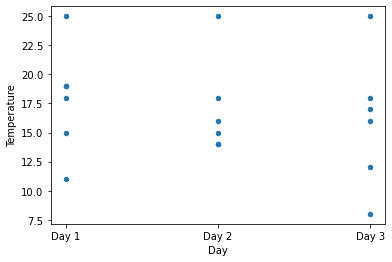

In [3]:
sample_dataframe.plot("Day","Temperature",kind="scatter")

The format of the plot command is "name of dataframe".plot("variable to plot on x-axis", "variable to plot on y-axis", kind="scatter") in order to generate a scatter plot.

For our data it is not clear if there are outliers due to the small number of datapoints we included, but from how we created the data it is safe to assume there will be no outliers.

The final two assumptions are handled with statistical tests. The assumption of normality is tested with a Shapiro-Wilk test, and equal variance with a Levene test (as we showed in module 1).

The Shapiro-Wilk test is also done using the stats module with the stats.shapiro function, but we will first have to separate our data as we did in module 1 (compressed a little bit):

In [4]:
dependent_variable_data = pandas.DataFrame(columns=[day for day in pandas.unique(sample_dataframe['Day'])])
for day in pandas.unique(sample_dataframe['Day']):
    dependent_variable_data[day] = sample_dataframe["Temperature"][sample_dataframe["Day"]==day].reset_index(drop=True)
dependent_variable_data

,Day 1,Day 2,Day 3
0,11,14,8
1,15,15,18
2,19,16,17
3,25,25,25
4,19,14,16
5,18,18,12


Now we can do the shapiro test for any, or all, of the columns, like we did the levene test before.

In [5]:
for day in dependent_variable_data.columns:
    print(day, stats.shapiro(dependent_variable_data[day]))

Day 1 ShapiroResult(statistic=0.9583392143249512, pvalue=0.806853711605072)
Day 2 ShapiroResult(statistic=0.7797852754592896, pvalue=0.038368575274944305)
Day 3 ShapiroResult(statistic=0.972091555595398, pvalue=0.9061785936355591)


If the $p$ value is larger than our significance level we fail to reject the null hypothesis, which in this case was that the data is normally distributed.

Just to remind you, we will do the same thing with the levene test:

In [6]:
for day1,day2 in itertools.combinations(dependent_variable_data.columns,2):
    print(day1,day2, stats.levene(dependent_variable_data[day1],dependent_variable_data[day2]))

Day 1 Day 2 LeveneResult(statistic=0.06807866868381239, pvalue=0.7994496065333374)
Day 1 Day 3 LeveneResult(statistic=0.169606512890095, pvalue=0.6891503330437265)
Day 2 Day 3 LeveneResult(statistic=0.4092071611253198, pvalue=0.5367510569219951)


Now with all the assumptions checked we will do the ANOVA. We use the method, and notation, from the course book. The function in the code block below contains comments explaining some of the steps.

In [7]:
def ANOVA(dataset,independent,dependent,confidence = 0.95):
    """ Calculates the ANOVA for a given dataset and prints an ANOVA table
        and results of post hoc test if test was performed.

    Args:  # 'arguments', or inputs to the function
        dataset (pandas.DataFrame): The data
        independent (string): The name of the independent column.
        dependent (string): The name of the dependent column.
        confidence (float): The desired confidence level for the ANOVA.

    Returns:
        None.
    """
    groups = pandas.unique(dataset[independent])
    k = len(groups)  # number of groups
    n = len(dataset[dependent])  # number of dependent data points

    # here we calculate the three degrees of freedom used in the ANOVA
    DFbetween = k - 1
    DFwithin = n - k
    DFtotal = n - 1

    # we use textbook notation:
    # x_dd = sum over i and j x_ij
    # x_id = sum over j x_ij
    # x_dj = sum over i x_ij
    # where i is the independent variable and j is the dependent variable

    x_dd = sum(dataset[dependent])
    CF = (x_dd**2)/n

    SStotal = sum(x_ij**2 for x_ij in dataset[dependent]) - CF

    SSbetween = 0
    for i in groups:
        group_data = dataset.loc[dataset[independent]==i]
        n_i = len(group_data[dependent])
        x_id = sum(group_data[dependent])
        SSbetween += (x_id**2)/n_i

    SSbetween = SSbetween - CF # so^2 - s^2

    SSwithin = SStotal - SSbetween

    MSbetween = SSbetween/DFbetween
    MSwithin = SSwithin/DFwithin

    F = MSbetween/MSwithin
    p = stats.f.sf(F, DFbetween, DFwithin)

    print(tabulate([['Between', DFbetween, SSbetween, MSbetween, F],
                    ['Within', DFwithin, SSwithin, MSwithin, ' '],
                    ['Total', DFtotal, SStotal, ' ', ' ']],
    headers=['Variation due to', 'DoF','Sum of squares','mean squares','F ratio']))
    print('Significance (p value): '+str(p))
    print('\n')
    alpha = 1-confidence
    if p<alpha:
        print("Reject null-hypothesis: There are statistical differences present.")
        print(pairwise_tukeyhsd(dataset[dependent], dataset[independent],alpha=alpha))
    else:
        print("Fail to reject the null-hypothesis: There are no statistical differences present at this level of significance.")

We call the ANOVA on our original dataset, not the one where we separated the dependent variable into groups based on the independent variable.

In [8]:
ANOVA(sample_dataframe,"Day","Temperature",confidence = 0.95)

Variation due to      DoF    Sum of squares  mean squares       F ratio
------------------  -----  ----------------  -----------------  -------------------
Between                 2           10.1111  5.055555555555657  0.20900321543408795
Within                 15          362.833   24.18888888888887
Total                  17          372.944
Significance (p value): 0.8137158477826968


Fail to reject the null-hypothesis: There are no statistical differences present at this level of significance.
